In [2]:
from xgboost import XGBRegressor as XGBR
from sklearn.linear_model import LinearRegression as LR
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def preproc(_df):
    _df['강수량(mm)']=_df['강수량(mm)'].fillna(0)
    _df['적설(cm)']=_df['적설(cm)'].fillna(0)
    _df=_df.dropna(axis=0)
    return _df

In [4]:
df=pd.read_csv("OBS_ASOS_TIM_20230318155150.csv",encoding='cp949')
df2=pd.read_csv("OBS_ASOS_TIM_20230317173225.csv",encoding='cp949')
df=preproc(df)
df2=preproc(df2)

In [5]:
def calcByMagnus_Tetens(air_temperature,humidity,atm_pressure):
    alpha = 17.27
    beta = 237.7
    gamma = ((alpha * air_temperature) / (beta + air_temperature)) + math.log(humidity/100.0)
    es = 6.112 * math.exp(gamma) * (atm_pressure/1013.25)**(1.0 - 0.00075 * air_temperature)
    gamma_dp = math.log(es/6.112)
    dew_point = (beta * gamma_dp) / (alpha - gamma_dp)
    return dew_point

In [6]:
ld=XGBR()
ld.fit(df[['기온(°C)', '강수량(mm)', '습도(%)','현지기압(hPa)', '적설(cm)', '지면온도(°C)']],df['이슬점온도(°C)'])
ld.score(df2[['기온(°C)', '강수량(mm)', '습도(%)','현지기압(hPa)', '적설(cm)', '지면온도(°C)']],df2['이슬점온도(°C)'])

0.9995827204581111

In [7]:
df2['out_MT']=df2.apply(lambda x:calcByMagnus_Tetens(x['기온(°C)'],x['습도(%)'],x['현지기압(hPa)']),axis=1)
df2['out_XGGR']=ld.predict(df2[['기온(°C)', '강수량(mm)', '습도(%)',
       '현지기압(hPa)', '적설(cm)', '지면온도(°C)']])

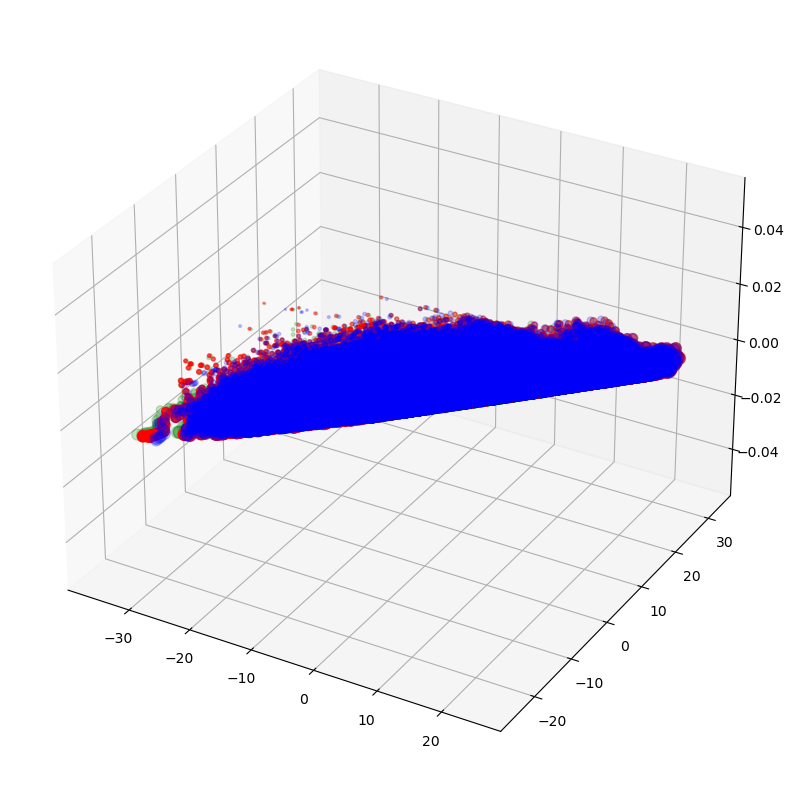

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(df2['out_MT'],df2['기온(°C)'],df2['습도(%)'],c='g',alpha=0.2)
plt.scatter(df2['out_XGGR'],df2['기온(°C)'],df2['습도(%)'],c='b',alpha=0.2)
plt.scatter(df2['이슬점온도(°C)'],df2['기온(°C)'],df2['습도(%)'],c='r')

In [10]:
def get_r2_score(y_true, y_pred):
    from sklearn.metrics import r2_score
    return r2_score(y_true, y_pred)
def get_rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [11]:
print('R2 MT: ',get_r2_score(df2['이슬점온도(°C)'],df2['out_MT']))
print('R2 XGGR: ',get_r2_score(df2['이슬점온도(°C)'],df2['out_XGGR']))

R2 MT:  0.9995357003089701
R2 XGGR:  0.9995827204581111


In [14]:
print('RMSE MT: ',get_rmse(df2['이슬점온도(°C)'],df2['out_MT']))
print('RMSE XGGR: ',get_rmse(df2['이슬점온도(°C)'],df2['out_XGGR']))

RMSE MT:  0.18869401623225254
RMSE XGGR:  0.17888440360783914


In [16]:
print('MAX ABS ERROR MT: ',abs(df2['out_MT']-df2['이슬점온도(°C)']).max())
print('MAX ABS ERROR XGGR: ',abs(df2['out_XGGR']-df2['이슬점온도(°C)']).max())

MAX ABS ERROR MT:  1.4554768746932076
MAX ABS ERROR XGGR:  5.02352600097656


In [19]:
df2[['이슬점온도(°C)','out_MT','out_XGGR']].to_csv('compare.csv',index=False, encoding='cp949')